## VRP
reference: 
- https://en.wikipedia.org/wiki/Vehicle_routing_problem
- https://www.zhihu.com/question/275293660

![image](Figure_illustrating_the_vehicle_routing_problem.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def generate_data():
    size = 14
    X = np.random.random(size)
    Y = np.random.random(size)

    plt.figure('data')
    plt.scatter(X,Y,alpha=0.25)
    plt.show()

    data = pd.DataFrame({'X':X, 'Y':Y})
    data.index.name = 'id'
    data.head()
    data.to_csv('data/coordnates.csv')

generate_data()

<Figure size 640x480 with 1 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
coordinates = pd.read_csv('data/coordnates.csv')
coordinates = {str(int(_id)):(x,y) for _id, x, y in coordinates[['id', 'X', 'Y']].values}
coordinates

{'0': (0.7915076062156947, 0.7488658720612191),
 '1': (0.8649143780219218, 0.7077529768859602),
 '2': (0.8302620579343899, 0.9888863651948716),
 '3': (0.7002288003241011, 0.4783941390969658),
 '4': (0.9068192377054546, 0.9424462712183712),
 '5': (0.7202714456391925, 0.9494859615302874),
 '6': (0.5334952631453498, 0.5706051171609674),
 '7': (0.6696201293333233, 0.7436526353796343),
 '8': (0.7668000078396771, 0.7818314229034862),
 '9': (0.2819913473765687, 0.0913995249815578),
 '10': (0.7058678205896888, 0.6862398436848699),
 '11': (0.06275926401260712, 0.034894522016488135),
 '12': (0.9103497843766508, 0.11864572767069048),
 '13': (0.47880055892191203, 0.29823717465250604)}

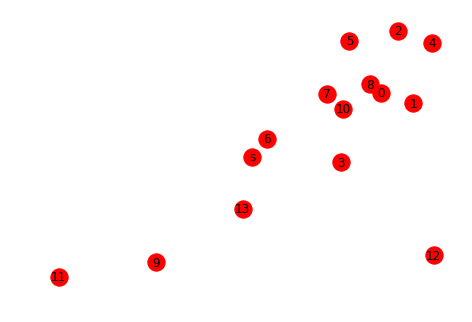

In [3]:
import networkx as nx
coordinates['s'] = (0.5, 0.5)
graph = nx.Graph()
graph.add_nodes_from(coordinates.keys())
nx.draw(graph, coordinates, with_labels=True)

In [4]:
from functools import lru_cache
from math import sqrt
import debug_tools
import time

#p2p refers to point to point
@lru_cache(15*15)
def get_p2p_distance(point1:str, point2:str):
    global coordinates
    x1, y1 = coordinates[point1]
    x2, y2 = coordinates[point2]
    return sqrt((x1-x2)**2 + (y1-y2)**2)

# @debug_tools.debug_print
def visulize_trace(trace):
    global coordinates
    edges = {s:[e] for s, e in trace}
    graph = nx.DiGraph(edges)
    graph.add_nodes_from(coordinates.keys())
    nx.draw(graph, coordinates, with_labels=True)
    plt.show()

## TSP Dynamic Programming solution

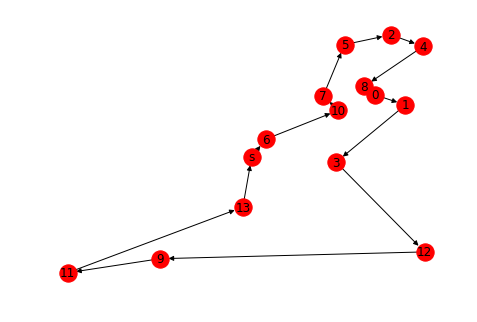

[('s', '6'), ('6', '10'), ('10', '7'), ('7', '5'), ('5', '2'), ('2', '4'), ('4', '8'), ('8', '0'), ('0', '1'), ('1', '3'), ('3', '12'), ('12', '9'), ('9', '11'), ('11', '13'), ('13', 's')]
3.3599500473711474


In [5]:
class route:
    def __init__(self, trace):
        global coordinates
        self.trace  = trace # a list of tuple (edges)
        self.length = sum([get_p2p_distance(*e) for e in trace])
    
    def add(self, node):
        end_of_trace = self.trace[-1][-1]
        new_route = route([])
        new_route.trace = self.trace  + [(end_of_trace, node)]
        new_route.length = self.length + get_p2p_distance(end_of_trace, node)
        return new_route

debug_tools.stack_level = 0

@lru_cache(maxsize=10**10)
def opt_route(need_visited, end):
    if len(need_visited) == 0:
        return route([(end, 's')])
    # need_visited is a set of node
    if len(need_visited) == 1:
        return route([('s', need_visited[0])])
    else:
        S = tuple([n for n in need_visited if n!=end])
        routes = [opt_route(S, n).add(end) for n in S]
        return min(routes, key=lambda r: r.length)


need_visited = tuple([e for e in coordinates.keys() if e != 's'])
best_route = opt_route(need_visited,'s')
visulize_trace(best_route.trace)
print(best_route.trace)
print(best_route.length)

## VRP Dynamic Programming with heuristic function

[<__main__.route object at 0x7f1f0d131f60>, <__main__.route object at 0x7f1f0ce25898>, <__main__.route object at 0x7f1f0cf367f0>] 5.059773642751129


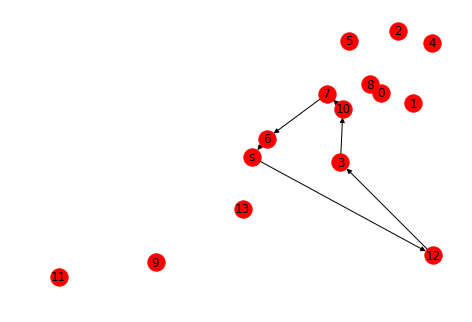

1.5509504812527606 [('s', '12'), ('12', '3'), ('3', '10'), ('10', '7'), ('7', '6'), ('6', 's')]


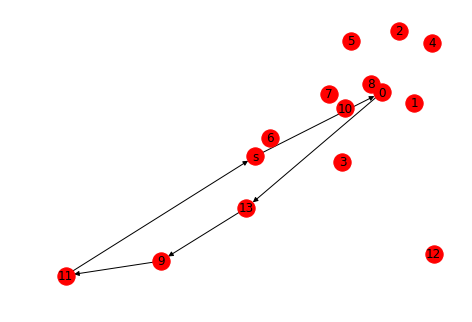

2.0820548942334245 [('s', '0'), ('0', '13'), ('13', '9'), ('9', '11'), ('11', 's')]


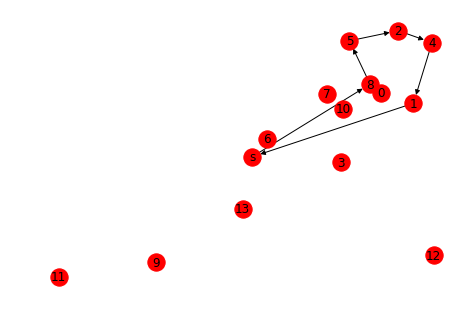

1.426768267264944 [('s', '8'), ('8', '5'), ('5', '2'), ('2', '4'), ('4', '1'), ('1', 's')]


In [6]:
from itertools import chain, combinations
import math

def power_set(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)" 
    result = []
    for r in range(2, math.ceil(len(iterable)/2)):
        result += list(combinations(iterable, r))
    return result

class route_group:
    def __init__(self, routes:list):
        self.routes = routes
        self.length = 0 if routes==[] else sum([r.length for r in routes])
    
    def add(self, g):
        new_group = route_group([])
        new_group.routes = self.routes + g.routes
        new_group.length = self.length + g.length
        return new_group
    
    def get_group(self):
        return [r.trace for r in self.routes]

def tsp(U):
    return route_group([opt_route(U,'s')])


def strategy_func(group):
    #this is a heuristic function for this dynamic programming
    #group contains routes for each vehicle
    #this strategy consider both cost on node and length
    cost_per_node = 0.5
    cost_per_length = 1
    return max([cost_per_node*len(r.trace) + cost_per_length*r.length for r in group.routes])
    

# @debug_tools.debug_print
@lru_cache(maxsize=10**10)
def vrp(U, k):
    if k==1:
        return tsp(U)
    else:
        groups = []
        for u in power_set(U):
            complementary_set = tuple([n for n in U if n not in u])
            group = vrp(complementary_set, k-1).add(tsp(u))
            groups.append(group)
            
        return min(groups, key=strategy_func)


need_visited = tuple([e for e in coordinates.keys() if e != 's'])
best_route = vrp(need_visited,3)
print(best_route.routes, best_route.length)
for r in best_route.routes:
    visulize_trace(r.trace)
    print(r.length, r.trace)